### Using KDiffusion model, with pretrained UNet encoder.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['OMP_NUM_THREADS']='1'

In [2]:
#!pip install -q diffusers datasets wandb lpips timm

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: jantic. Use `wandb login --relogin` to force relogin


True

In [4]:
#@title imports
import wandb
import torch
import torchvision
from torch import nn
from torch import multiprocessing as mp
from torch.utils import data
from torchvision import datasets, transforms
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.vision.models.unet import _get_sz_change_idxs
from timm.optim.rmsprop_tf import RMSpropTF
from timm.optim.lookahead import Lookahead
from timm.optim.lamb import Lamb
from torch.nn.utils import spectral_norm
import timm
import accelerate
from einops import rearrange
from functools import partial
import math
from copy import deepcopy
from pathlib import Path
from tqdm.auto import trange, tqdm
import k_diffusion as K
from k_diffusion.models.image_v1 import *
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cuda


In [5]:
def RmsLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    rmsprop = RMSpropTF(params, *args, **kwargs)
    return Lookahead(rmsprop, alpha, k)

In [6]:
def AdamLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    opt = torch.optim.AdamW(params, betas=(0.95, 0.999), eps=1e-6, *args, **kwargs)
    return Lookahead(opt, alpha, k)

In [7]:
def convnext_large(pretrained:bool=False, **kwargs):
    return timm.create_model('convnext_large_384_in22ft1k', pretrained=pretrained)

In [8]:
def resnext101_32x16d_wsl(pretrained:bool=False, **kwargs):
    return torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl') 

In [9]:
#Training Config
num_epochs = 15
unfreeze_epoch = int(0.3*num_epochs)
bs = 128 # the batch size
grad_accum_steps = 1 # the number of gradient accumulation steps
max_lr = 5e-4 # the max learning rate
num_workers = 8 # the number of data loader workers
resume = None # the checkpoint to resume from
save_every = 10000 # save every this many steps
training_seed = None # the random seed for training
start_method = 'spawn' # the multiprocessing start method. Options: 'fork', 'forkserver', 'spawn'

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#encoder_arch = resnext101_32x16d_wsl
#encoder_cut = -2
encoder_arch = convnext_large
encoder_cut = -6
mean, std = imagenet_stats

opt_func = partial(torch.optim.AdamW, lr=max_lr, betas=(0.95, 0.999),
                  eps=1e-6, weight_decay=1e-3) 
#opt_func = partial(RmsLookahead, lr=max_lr, weight_decay=1e-3) 

#opt_func = partial(RMSpropTF, lr=max_lr, weight_decay=1e-3) 

#Logging Config
sample_n = 64 # the number of images to sample for demo grids
demo_every = 250 # save a demo grid every this many steps
#evaluate_every = 10000 # save a demo grid every this many steps
evaluate_every = 0 #disabled
evaluate_n = 50000 # the number of samples to draw to evaluate
name = 'KDiff_CelebA_PretrainedEncoderUnet' # the name of the run
wandb_project = 'FastDiffusion_KDiff_CelebA' # the wandb project name (specify this to enable wandb)
wandb_save_model = False # save model to wandb
dataset_name = 'CelebA' # wandb name for dataset used
comments = 'Pretrained Encoder based Unet run of K-diffusion model on CelebA.' # comments logged in wandb
demo_imgs_dir = './demo_images'
metrics_dir = './metrics'

#Model Config
sz = 64
size = [sz,sz]
input_channels = 3
patch_size= 1
mapping_out= 256
compress_factor = 4

#UBlock Only
#depths= [8, 8, 8, 4, 4]
#channels= [1024, 512, 256, 256, 128]
#self_attn_depths = [True, True, False, False, False]


#UBlock Only
depths= [4, 4, 2, 2]
channels= [512, 512, 256, 256]
self_attn_depths = [True, True, False, False]

#depths= [4, 4, 2]
#channels= [512, 256, 128]
#self_attn_depths = [True, True, False]


cross_attn_depths = None

has_variance = True
dropout_rate = 0.05
augment_wrapper = True
augment_prob = 0.12
sigma_data = 0.5
sigma_min = 1e-2
sigma_max = 80
skip_stages = 0
augment_prob = 0.12
sigma_min = 1e-2
sigma_max = 80

#Model Save/Load
checkpoints_dir = './checkpoints'
model_path = Path(checkpoints_dir +'/' + name + '.pt')
model_ema_path = Path(checkpoints_dir +'/' + name + '_ema.pt')
model_path.parent.mkdir(exist_ok=True)

In [10]:
mp.set_start_method(start_method)
torch.backends.cuda.matmul.allow_tf32 = True

In [11]:
ddp_kwargs = accelerate.DistributedDataParallelKwargs(find_unused_parameters=skip_stages > 0)
accelerator = accelerate.Accelerator(kwargs_handlers=[ddp_kwargs], gradient_accumulation_steps=grad_accum_steps, mixed_precision='fp16')
device = accelerator.device
print(f'Process {accelerator.process_index} using device: {device}', flush=True)

Process 0 using device: cuda


# Model and Training Setup

In [12]:
def make_sample_density(mean=-1.2, std=1.2):
    #lognormal
    return partial(K.utils.rand_log_normal, loc=mean, scale=std)

In [13]:
def make_sequential_model(model, cut:int=None):
    flattened = list()

    for child in model.children():
        if isinstance(child, nn.Sequential):
            flattened.extend(child.children())
        else:
            flattened.append(child)            

    if cut is None:
        return nn.Sequential(*flattened)
    else:
        return nn.Sequential(*flattened[:cut])


In [14]:
encoder = encoder_arch(pretrained=True)
encoder = make_sequential_model(encoder, encoder_cut)

In [15]:
class CompressBlock(layers.ConditionedSequential):
    def __init__(self, feats_in, c_in, c_out, group_size=32, dropout_rate=0., self_attn=False, cross_attn=False, c_enc=0):
        modules = []
        modules.append(spectral_norm(nn.Conv2d(c_in, c_out, 1)))
        #modules.append(nn.Conv2d(c_in, c_out, 3, padding=1))
        modules.append(nn.Dropout2d(dropout_rate, inplace=True))
        modules.append(K.layers.AdaGN(feats_in, c_out, max(1, c_out // group_size)))
        modules.append(nn.GELU())
        #modules.append(ResConvBlock(feats_in, c_out, c_out, c_out, group_size, dropout_rate))
        modules.append(UBlock(n_layers=1, feats_in=feats_in, c_in=c_out, c_mid=c_out, c_out=c_out, dropout_rate=dropout_rate, upsample=False, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc, group_size=group_size))
        super().__init__(*modules)

    def forward(self, input, cond, skip=None):
        if skip is not None:
            input = torch.cat([input, skip], dim=1)
        return super().forward(input, cond)

In [16]:
class CustUBlock(nn.Module):
    def __init__(self, n_layers, feats_in, c_in, c_mid, c_out, dropout_rate=0., up_c_in=0, compress_factor=4, upsample=False, self_attn=False, cross_attn=False, c_enc=0):
        super().__init__()
        if up_c_in > 0: 
            c_in_big = c_in + up_c_in
            up_c_in_comp = up_c_in//compress_factor
            self.c1_block = CompressBlock(feats_in, c_in_big, up_c_in_comp, dropout_rate=dropout_rate, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)
            c_in_bigger = c_in + up_c_in_comp + up_c_in
            self.c2_block = CompressBlock(feats_in, c_in_bigger, c_in, dropout_rate=dropout_rate, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)
        else:
            self.c1_block = nn.Identity()
            self.c2_blocks = nn.Identity()    
    
        self.u_block = UBlock(n_layers=n_layers, feats_in=feats_in, c_in=c_in, c_mid=c_mid, c_out=c_out, dropout_rate=dropout_rate, upsample=upsample, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)

    def forward(self, input, cond, skip=None):
        if skip is not None:
            skip_comp = torch.cat([input, skip], dim=1)
            skip_comp = self.c1_block(skip_comp, cond)
            input = torch.cat([input, skip, skip_comp], dim=1)
            input = self.c2_block(input, cond)
        return self.u_block(input, cond)

In [17]:
class OutBlock(nn.Module):
    def __init__(self, n_layers, feats_in, c_in, c_in_comp, c_mid, c_out, dropout_rate=0., self_attn=False, cross_attn=False, 
                 c_enc=0, group_size=32):
        super().__init__()        
        self.c1_block = CompressBlock(feats_in, c_in, c_in_comp, dropout_rate=dropout_rate)
        self.u_block1 = UBlock(n_layers=n_layers, feats_in=feats_in, c_in=c_in_comp, c_mid=c_in_comp, c_out=c_in_comp, dropout_rate=dropout_rate, upsample=False, 
                 self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)
        c_in_big = c_in_comp + c_in
        self.c2_block = CompressBlock(feats_in, c_in_big, c_mid, dropout_rate=dropout_rate)
        self.u_block2 = UBlock(n_layers=n_layers, feats_in=feats_in, c_in=c_mid, c_mid=c_mid, c_out=c_out, dropout_rate=dropout_rate, upsample=False, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)

    def forward(self, input, cond):
        input_comp = self.c1_block(input, cond)
        input_comp = self.u_block1(input_comp, cond, None)
        input_comp = torch.cat([input, input_comp], dim=1)
        input_comp = self.c2_block(input_comp, cond)
        return self.u_block2(input_comp, cond, None)

In [18]:
class InitBlock(K.layers.ConditionedModule):
    def __init__(self, n_layers, feats_in, c_in, c_out, ks=2, stride=2, group_size=32, dropout_rate=0.0, c_enc=0):
        super().__init__() 
        layers = [nn.Conv2d(c_in, c_out, ks, stride=(stride,stride)),
                K.layers.AdaGN(feats_in, c_out, max(1, c_out // group_size)),
                DBlock(n_layers=n_layers, feats_in=feats_in, c_in=c_out, c_mid=c_out, c_out=c_out, dropout_rate=dropout_rate, downsample=False, 
                         self_attn=False, cross_attn=False, c_enc=c_enc)]
        
        self.downsampler = K.layers.ConditionedSequential(*layers)
    
    def forward(self, input, cond):
        return self.downsampler(input, cond)


In [19]:
class EnhancedEncoder(K.layers.ConditionedSequential):
    def __init__(self, encoder, imsize, depths, self_attn_depths, cross_attn_depths, feats_in, c_in=3, dropout_rate=0., c_enc=0):
        sizes = model_sizes(encoder, imsize)
        sz_chg_idxs = _get_sz_change_idxs(sizes)
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        self.sizes = sizes
        orig_layers = []
        new_layers = []
        layers = []
        
        c_out = sizes[sz_chg_idxs[0]][1]
        
        init_block = InitBlock(n_layers=2, feats_in=feats_in, c_in=c_in, c_out=c_out, 
                               dropout_rate=dropout_rate,  ks=4, stride=4, c_enc=c_enc)
    
        #sz_chg_idxs = [0, *sz_chg_idxs]
        self.sz_chg_idxs = sz_chg_idxs
        layers.append(init_block)
        new_layers.append(init_block)
        
        for i in range(1, len(sz_chg_idxs)+1):
            start_idx = sz_chg_idxs[i-1]
            end_idx = sz_chg_idxs[i] if i < len(sz_chg_idxs) else len(encoder)
            orig_part = encoder[start_idx:end_idx]
            orig_layers.append(orig_part)
            layers.append(orig_part)
            c_in = sizes[min(end_idx-1, len(encoder)-1)][1]
            self_attn = self_attn_depths[len(self_attn_depths)-2-i]
            cross_attn = cross_attn_depths[len(cross_attn_depths)-2-i]
            n_layers = depths[len(depths)-2-i]       
            d_block = DBlock(n_layers=n_layers, feats_in=feats_in, c_in=c_in, c_mid=c_in, c_out=c_in, dropout_rate=dropout_rate, downsample=False, 
                         self_attn=self_attn, cross_attn=cross_attn, c_enc=c_enc)
            new_layers.append(d_block)
            layers.append(d_block)
        
        super().__init__(*layers)
        self.orig_layers = orig_layers
        self.new_layers = new_layers
        
    def toggle_orig_encoder_freeze(self, freeze=True):
        for layer in self.orig_layers:
            for param in layer.parameters():
                param.requires_grad = not freeze
        

In [20]:
class CustUNet(K.layers.ConditionedModule):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_out, img_size, depths, channels,
                 self_attn_depths, feats_in, mean, std, dropout_rate=0.0, cross_attn_depths=None, last_cross=True, 
                 group_size=32, cross_cond_dim=0, compress_factor=4, **kwargs):
        super().__init__()
        self.normalize = transforms.Normalize(mean=mean, std=std)
        imsize = img_size
        x = dummy_eval(encoder, imsize).detach()
        self.last_cross=last_cross
        self.encoder = EnhancedEncoder(encoder, imsize, depths=depths, self_attn_depths=self_attn_depths, cross_attn_depths=cross_attn_depths, 
                                       feats_in=feats_in, dropout_rate=dropout_rate)
                                       
        
        #sizes = model_sizes(self.encoder, size=imsize)
        #sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        #self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        
        sizes = self.encoder.sizes
        sz_chg_idxs = list(reversed(self.encoder.sz_chg_idxs))
        self.sfs = list(reversed(self.encoder.sfs))
        
        ni = sizes[-1][1]
        my_c_out = channels[0]
        
        #middle_conv = K.layers.ConditionedSequential(ResConvBlock(feats_in, ni, ni*2, my_c_out, dropout_rate=dropout_rate))
        middle_conv = K.layers.ConditionedSequential(ResConvBlock(feats_in, ni, ni//4, my_c_out, dropout_rate=dropout_rate))
        middle_layers = [K.layers.AdaGN(feats_in, ni, max(1, ni // group_size)), nn.GELU(), middle_conv]
        self.middle_block = K.layers.ConditionedSequential(*middle_layers)
        
        u_blocks = []

        for i in range(0, len(channels)):
            idx = sz_chg_idxs[i-1] if i > 0 else None
            up_c_in = 0 if idx is None else int(sizes[idx][1])
            my_c_out = channels[min(len(channels)-1, i+1)]            
            u_block = CustUBlock(depths[i], feats_in, channels[i], channels[i], my_c_out, up_c_in=up_c_in, upsample=True, self_attn=self_attn_depths[i], 
                             cross_attn=cross_attn_depths[i], c_enc=cross_cond_dim, dropout_rate=dropout_rate)
            
            u_blocks.append(u_block) 
             
        self.u_blocks = nn.ModuleList(u_blocks)   

        ni = my_c_out
        out_layers = []
        
        if last_cross:
            ni += in_channels(encoder)
            
        i = len(channels)-1
        ni_comp = (ni- ni%group_size)//compress_factor 
        self.out_block = OutBlock(depths[i], feats_in, ni, ni_comp, channels[i], n_out, self_attn=self_attn_depths[i], 
                            cross_attn=cross_attn_depths[i], c_enc=cross_cond_dim, dropout_rate=dropout_rate, 
                            group_size=group_size)
         

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
        
    def forward(self, input, cond):
        input = self.normalize(input)
        orig_input = input
        input = self.encoder(input, cond)
        input = self.middle_block(input, cond)
        
        for i, block in enumerate(self.u_blocks):
            skip = self.sfs[i-1].stored if i > 0 else None
            input = block(input, cond, skip)
        
        if orig_input.shape[-2:] != input.shape[-2:]:
            input = F.interpolate(input, orig_input.shape[-2:], mode='bicubic')
        
        if self.last_cross:
            input = torch.cat([input, orig_input], dim=1)
        
        input = self.out_block (input, cond)
        return input

In [21]:
class CustImageDenoiserModelV1(nn.Module):
    def __init__(self, c_in, feats_in, depths, channels, self_attn_depths, encoder, mean, std, cross_attn_depths=None, mapping_cond_dim=0, \
                 unet_cond_dim=0, cross_cond_dim=0, dropout_rate=0., patch_size=1, skip_stages=0, has_variance=False, compress_factor=4):
        super().__init__()
        self.c_in = c_in
        self.unet_cond_dim = unet_cond_dim
        self.patch_size = patch_size
        self.has_variance = has_variance
        self.timestep_embed = K.layers.FourierFeatures(1, feats_in)
        if mapping_cond_dim > 0:
            self.mapping_cond = nn.Linear(mapping_cond_dim, feats_in, bias=False)
        self.mapping = MappingNet(feats_in, feats_in)
        n_out = channels[-1]//4
        self.proj_out = nn.Conv2d(n_out, c_in * self.patch_size ** 2 + (1 if self.has_variance else 0), 1)
        nn.init.zeros_(self.proj_out.weight)
        nn.init.zeros_(self.proj_out.bias)
        if cross_cond_dim == 0:
            cross_attn_depths = [False] * len(self_attn_depths)
        self.u_net = CustUNet(encoder=encoder, n_out=n_out, img_size=(sz,sz), depths=depths, channels=channels, 
                              feats_in=feats_in, mean=mean, std=std, self_attn_depths=self_attn_depths, dropout_rate=dropout_rate, 
                              cross_attn_depths=cross_attn_depths, cross_cond_dim=cross_cond_dim, compress_factor=compress_factor)

    def forward(self, input, sigma, mapping_cond=None, unet_cond=None, cross_cond=None, cross_cond_padding=None, return_variance=False):
        c_noise = sigma.log() / 4
        timestep_embed = self.timestep_embed(utils.append_dims(c_noise, 2))
        mapping_cond_embed = torch.zeros_like(timestep_embed) if mapping_cond is None else self.mapping_cond(mapping_cond)
        mapping_out = self.mapping(timestep_embed + mapping_cond_embed)
        cond = {'cond': mapping_out}
        if unet_cond is not None:
            input = torch.cat([input, unet_cond], dim=1)
        if cross_cond is not None:
            cond['cross'] = cross_cond
            cond['cross_padding'] = cross_cond_padding
        if self.patch_size > 1:
            input = F.pixel_unshuffle(input, self.patch_size)
        input = self.u_net(input, cond)
        input = self.proj_out(input)
        if self.has_variance:
            input, logvar = input[:, :-1], input[:, -1].flatten(1).mean(1)
        if self.patch_size > 1:
            input = F.pixel_shuffle(input, self.patch_size)
        if self.has_variance and return_variance:
            return input, logvar
        return input

    def set_skip_stages(self, skip_stages):
        return

    def set_patch_size(self, patch_size):
        return

In [22]:
def make_model():
    model = CustImageDenoiserModelV1(
        c_in=input_channels,
        feats_in=mapping_out,
        depths=depths,
        channels=channels,
        self_attn_depths=self_attn_depths,
        cross_attn_depths=cross_attn_depths,
        patch_size=patch_size,
        dropout_rate=dropout_rate,
        mapping_cond_dim= 9 if augment_wrapper else 0,
        unet_cond_dim = 0,
        cross_cond_dim = 0,
        skip_stages= skip_stages,
        has_variance=has_variance,
        encoder=encoder,
        compress_factor=compress_factor,
        mean=mean,
        std=std
    )
    if augment_wrapper:
        model = K.augmentation.KarrasAugmentWrapper(model)
    return model

In [23]:
def make_denoiser_wrapper():
    if not has_variance:
        return partial(K.layers.Denoiser, sigma_data=sigma_data)
    return partial(K.layers.DenoiserWithVariance, sigma_data=sigma_data)

In [24]:
tfm = transforms.Compose([
    transforms.Resize(sz, interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.CenterCrop(sz),
    K.augmentation.KarrasAugmentationPipeline(augment_prob)
])

def tfms(examples):
    examples["image"] = [tfm(image.convert("RGB")) for image in examples["image"]]
    return examples

In [25]:
training_set = load_dataset('huggan/CelebA-faces')
tds = training_set.with_transform(tfms)['train']
dls = DataLoaders.from_dsets(tds, bs=bs)
train_dl = dls.train

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (F:/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [26]:
inner_model = make_model()

if accelerator.is_main_process:
    print('Parameters:', K.utils.n_params(inner_model))

model = make_denoiser_wrapper()(inner_model)

Parameters: 389588180


In [27]:
def init_wandb():
    import wandb
    log_config = {}
    log_config['num_epochs'] = 'N/A'
    log_config['max_lr'] = max_lr
    log_config['comments'] = comments
    log_config['dataset'] = dataset_name
    log_config['parameters'] = K.utils.n_params(inner_model)
    wandb.init(project=wandb_project, config=log_config, save_code=False)    

In [28]:
def init_training_manual_seed(accelerator):
    if training_seed is not None:
        seeds = torch.randint(-2 ** 63, 2 ** 63 - 1, [accelerator.num_processes], generator=torch.Generator().manual_seed(training_seed))
        torch.manual_seed(seeds[accelerator.process_index])    

In [29]:
def log_step_to_wandb(epoch, loss, step, sched, ema_decay):
    log_dict = {
        'epoch': epoch,
        'loss': loss.item(),
        'lr': sched.get_last_lr()[0],
        'ema_decay': ema_decay,
    }
    wandb.log(log_dict, step=step)

In [30]:
def write_progress_to_tdqm(epoch, step, loss):
    tqdm.write(f'Epoch: {epoch}, step: {step}, loss: {loss.item():g}')

In [31]:
model_ema = deepcopy(model).to(device)

In [32]:
opt = opt_func(inner_model.parameters())
init_training_manual_seed(accelerator)
use_wandb = accelerator.is_main_process and wandb_project
if use_wandb: init_wandb()
sched = K.utils.InverseLR(opt, inv_gamma=20000.0, power=1.0, warmup=0.99)
#total_steps = num_epochs * len(train_dl)
#sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr, total_steps=total_steps, pct_start=0.05)
ema_sched = K.utils.EMAWarmup(power=0.6667, max_value=0.9999)
image_key = 'image'

inner_model, opt, train_dl = accelerator.prepare(inner_model, opt, train_dl)
if use_wandb:
    wandb.watch(inner_model)

sample_density = make_sample_density()

epoch = 0
step = 0

In [33]:
evaluate_enabled = evaluate_every > 0 and evaluate_n > 0
extractor = None

if evaluate_enabled:
    extractor = K.evaluation.InceptionV3FeatureExtractor(device=device)
    train_iter = iter(train_dl)
    if accelerator.is_main_process:
        print('Computing features for reals...')
    reals_features = K.evaluation.compute_features(accelerator, lambda x: next(train_iter)[image_key][1].to(device), extractor, evaluate_n, bs)
    if accelerator.is_main_process:
        Path(metrics_dir).mkdir(exist_ok=True)
        metrics_log = K.utils.CSVLogger(f'{name}_metrics.csv', ['step', 'fid', 'kid'])
    del train_iter

In [34]:
@torch.no_grad()
def demo(model_ema, step, size):
    with K.utils.eval_mode(model_ema):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            if accelerator.is_main_process:
                tqdm.write('Sampling...')
            filename = f'{demo_imgs_dir}/{name}_demo_{step:08}.png'
            path = Path(filename)
            path.parent.mkdir(exist_ok=True)
            n_per_proc = math.ceil(sample_n / accelerator.num_processes)
            x = torch.randn([n_per_proc, input_channels, size[0], size[1]], device=device) * sigma_max
            sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
            x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=not accelerator.is_main_process)
            x_0 = accelerator.gather(x_0)[:sample_n]
            # For some reason the images are inverting...
            #x_0 = -x_0

            if accelerator.is_main_process:
                grid = torchvision.utils.make_grid(x_0, nrow=math.ceil(sample_n ** 0.5), padding=0)
                K.utils.to_pil_image(grid).save(filename)
                if use_wandb:
                    wandb.log({'demo_grid': wandb.Image(filename)}, step=step)

In [35]:
@torch.no_grad()
def evaluate(model_ema, step, size):
    with K.utils.eval_mode(model_ema):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            if not evaluate_enabled:
                return
            if accelerator.is_main_process:
                tqdm.write('Evaluating...')
            sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
            def sample_fn(n):
                x = torch.randn([n, input_channels, size[0], size[1]], device=device) * sigma_max
                x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=True)
                return x_0
            fakes_features = K.evaluation.compute_features(accelerator, sample_fn, extractor, evaluate_n, bs)
            if accelerator.is_main_process:
                fid = K.evaluation.fid(fakes_features, reals_features)
                kid = K.evaluation.kid(fakes_features, reals_features)
                print(f'FID: {fid.item():g}, KID: {kid.item():g}')
                if accelerator.is_main_process:
                    metrics_log.write(step, fid.item(), kid.item())
                if use_wandb:
                    wandb.log({'FID': fid.item(), 'KID': kid.item()}, step=step)

In [36]:
def save(step, epoch, opt, sched):
    accelerator.wait_for_everyone()
    filename = f'{checkpoints_dir}/{name}_{step:08}.pth'
    if accelerator.is_main_process:
        tqdm.write(f'Saving to {filename}...')
    obj = {
        'model': accelerator.unwrap_model(model.inner_model).state_dict(),
        'model_ema': accelerator.unwrap_model(model_ema.inner_model).state_dict(),
        'opt': opt.state_dict(),
        'sched': sched.state_dict(),
        'ema_sched': ema_sched.state_dict(),
        'epoch': epoch,
        'step': step
    }
    accelerator.save(obj, filename)

In [37]:
def toggle_encoder_freeze(model, model_ema, freeze=True):
    model.inner_model.inner_model.u_net.encoder.toggle_orig_encoder_freeze(freeze)
    model_ema.inner_model.inner_model.u_net.encoder.toggle_orig_encoder_freeze(freeze)
    return model, model_ema

In [38]:
model, model_ema = toggle_encoder_freeze(model, model_ema, freeze=True)

## Training Loop

In [39]:
try:
    ema_decay = None
    while epoch < num_epochs:
        for batch in tqdm(train_dl, disable=not accelerator.is_main_process):
            with accelerator.accumulate(model):
                reals, _, aug_cond = batch[image_key]
                reals = reals.to(device)
                aug_cond = aug_cond.to(device)
                noise = torch.randn_like(reals)
                sigma = sample_density([reals.shape[0]], device=device)
                losses = model.loss(reals, noise, sigma, aug_cond=aug_cond)
                losses_all = accelerator.gather(losses)
                loss = losses_all.mean()
                accelerator.backward(losses.mean())
                opt.step()
                sched.step()
                opt.zero_grad()
                if accelerator.sync_gradients:
                    ema_decay = ema_sched.get_value()
                    #print(next(model.parameters()).device, next(model_ema.parameters()).device)
                    K.utils.ema_update(model, model_ema, ema_decay)
                    ema_sched.step()

            if accelerator.is_main_process and step % 25 == 0:
                write_progress_to_tdqm(epoch, step, loss)

            if use_wandb: 
                log_step_to_wandb(epoch, loss, step, sched, ema_decay)

            if step % demo_every == 0:
                demo(model_ema, step, size)

            if evaluate_enabled and step > 0 and step % evaluate_every == 0:
                evaluate(model_ema, step, size)

            if step > 0 and step % save_every == 0:
                save(step, epoch, opt, sched)

            step += 1
        epoch += 1
        if epoch >= unfreeze_epoch:
            model, model_ema = toggle_encoder_freeze(model, model_ema, freeze=False)
            
except KeyboardInterrupt:
    pass

  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 0, step: 0, loss: 0.603311
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 25, loss: 0.488007
Epoch: 0, step: 50, loss: 0.377642
Epoch: 0, step: 75, loss: 0.320908
Epoch: 0, step: 100, loss: 0.257224
Epoch: 0, step: 125, loss: 0.0577593
Epoch: 0, step: 150, loss: -0.193003
Epoch: 0, step: 175, loss: -0.166336
Epoch: 0, step: 200, loss: -0.269955
Epoch: 0, step: 225, loss: -0.320933
Epoch: 0, step: 250, loss: -0.365333
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 275, loss: -0.367769
Epoch: 0, step: 300, loss: -0.399265
Epoch: 0, step: 325, loss: -0.377373
Epoch: 0, step: 350, loss: -0.43365
Epoch: 0, step: 375, loss: -0.376637
Epoch: 0, step: 400, loss: -0.399723
Epoch: 0, step: 425, loss: -0.429024
Epoch: 0, step: 450, loss: -0.434773
Epoch: 0, step: 475, loss: -0.439745
Epoch: 0, step: 500, loss: -0.461558
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 525, loss: -0.42512
Epoch: 0, step: 550, loss: -0.440756
Epoch: 0, step: 575, loss: -0.48577
Epoch: 0, step: 600, loss: -0.481508
Epoch: 0, step: 625, loss: -0.466948
Epoch: 0, step: 650, loss: -0.477848
Epoch: 0, step: 675, loss: -0.45745
Epoch: 0, step: 700, loss: -0.444603
Epoch: 0, step: 725, loss: -0.405408
Epoch: 0, step: 750, loss: -0.462665
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 775, loss: -0.501228
Epoch: 0, step: 800, loss: -0.46032
Epoch: 0, step: 825, loss: -0.454965
Epoch: 0, step: 850, loss: -0.484682
Epoch: 0, step: 875, loss: -0.445512
Epoch: 0, step: 900, loss: -0.518911
Epoch: 0, step: 925, loss: -0.503629
Epoch: 0, step: 950, loss: -0.47658
Epoch: 0, step: 975, loss: -0.470307
Epoch: 0, step: 1000, loss: -0.483722
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1025, loss: -0.457308
Epoch: 0, step: 1050, loss: -0.515191
Epoch: 0, step: 1075, loss: -0.516291
Epoch: 0, step: 1100, loss: -0.516194
Epoch: 0, step: 1125, loss: -0.487509
Epoch: 0, step: 1150, loss: -0.485124
Epoch: 0, step: 1175, loss: -0.449341
Epoch: 0, step: 1200, loss: -0.514579
Epoch: 0, step: 1225, loss: -0.511323
Epoch: 0, step: 1250, loss: -0.532005
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1275, loss: -0.506517
Epoch: 0, step: 1300, loss: -0.487458
Epoch: 0, step: 1325, loss: -0.4929
Epoch: 0, step: 1350, loss: -0.47216
Epoch: 0, step: 1375, loss: -0.524918
Epoch: 0, step: 1400, loss: -0.515733
Epoch: 0, step: 1425, loss: -0.509033
Epoch: 0, step: 1450, loss: -0.531522
Epoch: 0, step: 1475, loss: -0.51789
Epoch: 0, step: 1500, loss: -0.498725
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1525, loss: -0.50808
Epoch: 0, step: 1550, loss: -0.52505
Epoch: 0, step: 1575, loss: -0.530806


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 1, step: 1600, loss: -0.475889
Epoch: 1, step: 1625, loss: -0.536283
Epoch: 1, step: 1650, loss: -0.526736
Epoch: 1, step: 1675, loss: -0.522393
Epoch: 1, step: 1700, loss: -0.557921
Epoch: 1, step: 1725, loss: -0.518947
Epoch: 1, step: 1750, loss: -0.503199
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 1775, loss: -0.538272
Epoch: 1, step: 1800, loss: -0.541119
Epoch: 1, step: 1825, loss: -0.566027
Epoch: 1, step: 1850, loss: -0.571214
Epoch: 1, step: 1875, loss: -0.540191
Epoch: 1, step: 1900, loss: -0.553219
Epoch: 1, step: 1925, loss: -0.573423
Epoch: 1, step: 1950, loss: -0.525944
Epoch: 1, step: 1975, loss: -0.522592
Epoch: 1, step: 2000, loss: -0.524622
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 2025, loss: -0.554335
Epoch: 1, step: 2050, loss: -0.530312
Epoch: 1, step: 2075, loss: -0.549033
Epoch: 1, step: 2100, loss: -0.554628
Epoch: 1, step: 2125, loss: -0.548475
Epoch: 1, step: 2150, loss: -0.522258
Epoch: 1, step: 2175, loss: -0.550233
Epoch: 1, step: 2200, loss: -0.477312
Epoch: 1, step: 2225, loss: -0.530724
Epoch: 1, step: 2250, loss: -0.538677
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 2275, loss: -0.513404
Epoch: 1, step: 2300, loss: -0.528537
Epoch: 1, step: 2325, loss: -0.523107
Epoch: 1, step: 2350, loss: -0.546013
Epoch: 1, step: 2375, loss: -0.591656
Epoch: 1, step: 2400, loss: -0.546212
Epoch: 1, step: 2425, loss: -0.553404
Epoch: 1, step: 2450, loss: -0.557193
Epoch: 1, step: 2475, loss: -0.580267
Epoch: 1, step: 2500, loss: -0.561284
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 2525, loss: -0.512111
Epoch: 1, step: 2550, loss: -0.553407
Epoch: 1, step: 2575, loss: -0.586964
Epoch: 1, step: 2600, loss: -0.567743
Epoch: 1, step: 2625, loss: -0.556067
Epoch: 1, step: 2650, loss: -0.508042
Epoch: 1, step: 2675, loss: -0.53387
Epoch: 1, step: 2700, loss: -0.538892
Epoch: 1, step: 2725, loss: -0.539997
Epoch: 1, step: 2750, loss: -0.505473
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 2775, loss: -0.552242
Epoch: 1, step: 2800, loss: -0.555876
Epoch: 1, step: 2825, loss: -0.579983
Epoch: 1, step: 2850, loss: -0.521356
Epoch: 1, step: 2875, loss: -0.526001
Epoch: 1, step: 2900, loss: -0.572981
Epoch: 1, step: 2925, loss: -0.560705
Epoch: 1, step: 2950, loss: -0.569684
Epoch: 1, step: 2975, loss: -0.502842
Epoch: 1, step: 3000, loss: -0.538892
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 3025, loss: -0.556338
Epoch: 1, step: 3050, loss: -0.538185
Epoch: 1, step: 3075, loss: -0.560964
Epoch: 1, step: 3100, loss: -0.568836
Epoch: 1, step: 3125, loss: -0.600261
Epoch: 1, step: 3150, loss: -0.552615


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 2, step: 3175, loss: -0.528263
Epoch: 2, step: 3200, loss: -0.519765
Epoch: 2, step: 3225, loss: -0.589196
Epoch: 2, step: 3250, loss: -0.590798
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 3275, loss: -0.549265
Epoch: 2, step: 3300, loss: -0.538107
Epoch: 2, step: 3325, loss: -0.556315
Epoch: 2, step: 3350, loss: -0.55884
Epoch: 2, step: 3375, loss: -0.560768
Epoch: 2, step: 3400, loss: -0.563161
Epoch: 2, step: 3425, loss: -0.570976
Epoch: 2, step: 3450, loss: -0.587928
Epoch: 2, step: 3475, loss: -0.547986
Epoch: 2, step: 3500, loss: -0.511883
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 3525, loss: -0.629016
Epoch: 2, step: 3550, loss: -0.538752
Epoch: 2, step: 3575, loss: -0.535078
Epoch: 2, step: 3600, loss: -0.581755
Epoch: 2, step: 3625, loss: -0.593389
Epoch: 2, step: 3650, loss: -0.514978
Epoch: 2, step: 3675, loss: -0.552252
Epoch: 2, step: 3700, loss: -0.566945
Epoch: 2, step: 3725, loss: -0.590173
Epoch: 2, step: 3750, loss: -0.578234
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 3775, loss: -0.525793
Epoch: 2, step: 3800, loss: -0.567534
Epoch: 2, step: 3825, loss: -0.539839
Epoch: 2, step: 3850, loss: -0.51755
Epoch: 2, step: 3875, loss: -0.607564
Epoch: 2, step: 3900, loss: -0.56777
Epoch: 2, step: 3925, loss: -0.547338
Epoch: 2, step: 3950, loss: -0.563453
Epoch: 2, step: 3975, loss: -0.580323
Epoch: 2, step: 4000, loss: -0.512053
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 4025, loss: -0.5693
Epoch: 2, step: 4050, loss: -0.52858
Epoch: 2, step: 4075, loss: -0.596718
Epoch: 2, step: 4100, loss: -0.570476
Epoch: 2, step: 4125, loss: -0.557591
Epoch: 2, step: 4150, loss: -0.562507
Epoch: 2, step: 4175, loss: -0.561943
Epoch: 2, step: 4200, loss: -0.52912
Epoch: 2, step: 4225, loss: -0.568871
Epoch: 2, step: 4250, loss: -0.591755
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 4275, loss: -0.579395
Epoch: 2, step: 4300, loss: -0.614238
Epoch: 2, step: 4325, loss: -0.56896
Epoch: 2, step: 4350, loss: -0.580942
Epoch: 2, step: 4375, loss: -0.575104
Epoch: 2, step: 4400, loss: -0.515287
Epoch: 2, step: 4425, loss: -0.565431
Epoch: 2, step: 4450, loss: -0.62415
Epoch: 2, step: 4475, loss: -0.608828
Epoch: 2, step: 4500, loss: -0.561021
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 4525, loss: -0.609255
Epoch: 2, step: 4550, loss: -0.555033
Epoch: 2, step: 4575, loss: -0.586475
Epoch: 2, step: 4600, loss: -0.553522
Epoch: 2, step: 4625, loss: -0.566278
Epoch: 2, step: 4650, loss: -0.548771
Epoch: 2, step: 4675, loss: -0.580398
Epoch: 2, step: 4700, loss: -0.616084
Epoch: 2, step: 4725, loss: -0.569045


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 3, step: 4750, loss: -0.567986
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 4775, loss: -0.557486
Epoch: 3, step: 4800, loss: -0.603511
Epoch: 3, step: 4825, loss: -0.553178
Epoch: 3, step: 4850, loss: -0.582205
Epoch: 3, step: 4875, loss: -0.616574
Epoch: 3, step: 4900, loss: -0.547155
Epoch: 3, step: 4925, loss: -0.524795
Epoch: 3, step: 4950, loss: -0.548988
Epoch: 3, step: 4975, loss: -0.594446
Epoch: 3, step: 5000, loss: -0.553715
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 5025, loss: -0.564401
Epoch: 3, step: 5050, loss: -0.625241
Epoch: 3, step: 5075, loss: -0.559797
Epoch: 3, step: 5100, loss: -0.597541
Epoch: 3, step: 5125, loss: -0.58319
Epoch: 3, step: 5150, loss: -0.542133
Epoch: 3, step: 5175, loss: -0.589029
Epoch: 3, step: 5200, loss: -0.591327
Epoch: 3, step: 5225, loss: -0.596457
Epoch: 3, step: 5250, loss: -0.577992
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 5275, loss: -0.55526
Epoch: 3, step: 5300, loss: -0.544718
Epoch: 3, step: 5325, loss: -0.572402
Epoch: 3, step: 5350, loss: -0.601313
Epoch: 3, step: 5375, loss: -0.589101
Epoch: 3, step: 5400, loss: -0.601623
Epoch: 3, step: 5425, loss: -0.550578
Epoch: 3, step: 5450, loss: -0.552221
Epoch: 3, step: 5475, loss: -0.600744
Epoch: 3, step: 5500, loss: -0.597489
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 5525, loss: -0.576226
Epoch: 3, step: 5550, loss: -0.56854
Epoch: 3, step: 5575, loss: -0.617382
Epoch: 3, step: 5600, loss: -0.52996
Epoch: 3, step: 5625, loss: -0.629726
Epoch: 3, step: 5650, loss: -0.597367
Epoch: 3, step: 5675, loss: -0.566279
Epoch: 3, step: 5700, loss: -0.580489
Epoch: 3, step: 5725, loss: -0.597225
Epoch: 3, step: 5750, loss: -0.572452
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 5775, loss: -0.581337
Epoch: 3, step: 5800, loss: -0.582081
Epoch: 3, step: 5825, loss: -0.515914
Epoch: 3, step: 5850, loss: -0.585298
Epoch: 3, step: 5875, loss: -0.552856
Epoch: 3, step: 5900, loss: -0.550939
Epoch: 3, step: 5925, loss: -0.55544
Epoch: 3, step: 5950, loss: -0.595708
Epoch: 3, step: 5975, loss: -0.591114
Epoch: 3, step: 6000, loss: -0.557019
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 6025, loss: -0.543298
Epoch: 3, step: 6050, loss: -0.587692
Epoch: 3, step: 6075, loss: -0.57536
Epoch: 3, step: 6100, loss: -0.605021
Epoch: 3, step: 6125, loss: -0.566399
Epoch: 3, step: 6150, loss: -0.568523
Epoch: 3, step: 6175, loss: -0.550075
Epoch: 3, step: 6200, loss: -0.593834
Epoch: 3, step: 6225, loss: -0.589518
Epoch: 3, step: 6250, loss: -0.600877
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 6275, loss: -0.552936
Epoch: 3, step: 6300, loss: -0.580363
Epoch: 3, step: 6325, loss: -0.587335


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 4, step: 6350, loss: -0.59083
Epoch: 4, step: 6375, loss: -0.568685
Epoch: 4, step: 6400, loss: -0.612038
Epoch: 4, step: 6425, loss: -0.553297
Epoch: 4, step: 6450, loss: -0.623366
Epoch: 4, step: 6475, loss: -0.525669
Epoch: 4, step: 6500, loss: -0.59177
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 6525, loss: -0.601699
Epoch: 4, step: 6550, loss: -0.565625
Epoch: 4, step: 6575, loss: -0.591861
Epoch: 4, step: 6600, loss: -0.566728
Epoch: 4, step: 6625, loss: -0.580293
Epoch: 4, step: 6650, loss: -0.543919
Epoch: 4, step: 6675, loss: -0.547428
Epoch: 4, step: 6700, loss: -0.585015
Epoch: 4, step: 6725, loss: -0.586421
Epoch: 4, step: 6750, loss: -0.608917
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 6775, loss: -0.591754
Epoch: 4, step: 6800, loss: -0.590601
Epoch: 4, step: 6825, loss: -0.571371
Epoch: 4, step: 6850, loss: -0.530411
Epoch: 4, step: 6875, loss: -0.565814
Epoch: 4, step: 6900, loss: -0.566592
Epoch: 4, step: 6925, loss: -0.576136
Epoch: 4, step: 6950, loss: -0.584368
Epoch: 4, step: 6975, loss: -0.596492
Epoch: 4, step: 7000, loss: -0.582537
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 7025, loss: -0.5694
Epoch: 4, step: 7050, loss: -0.571298
Epoch: 4, step: 7075, loss: -0.581756
Epoch: 4, step: 7100, loss: -0.5646
Epoch: 4, step: 7125, loss: -0.592424
Epoch: 4, step: 7150, loss: -0.577997
Epoch: 4, step: 7175, loss: -0.590348
Epoch: 4, step: 7200, loss: -0.571011
Epoch: 4, step: 7225, loss: -0.56775
Epoch: 4, step: 7250, loss: -0.592891
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 7275, loss: -0.537117
Epoch: 4, step: 7300, loss: -0.569258
Epoch: 4, step: 7325, loss: -0.554933
Epoch: 4, step: 7350, loss: -0.586961
Epoch: 4, step: 7375, loss: -0.58573
Epoch: 4, step: 7400, loss: -0.585613
Epoch: 4, step: 7425, loss: -0.566439
Epoch: 4, step: 7450, loss: -0.553248
Epoch: 4, step: 7475, loss: -0.603407
Epoch: 4, step: 7500, loss: -0.560935
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 7525, loss: -0.60473
Epoch: 4, step: 7550, loss: -0.557979
Epoch: 4, step: 7575, loss: -0.542857
Epoch: 4, step: 7600, loss: -0.594705
Epoch: 4, step: 7625, loss: -0.577533
Epoch: 4, step: 7650, loss: -0.589127
Epoch: 4, step: 7675, loss: -0.60769
Epoch: 4, step: 7700, loss: -0.645871
Epoch: 4, step: 7725, loss: -0.611119
Epoch: 4, step: 7750, loss: -0.57009
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, step: 7775, loss: -0.565598
Epoch: 4, step: 7800, loss: -0.604282
Epoch: 4, step: 7825, loss: -0.578033
Epoch: 4, step: 7850, loss: -0.550326
Epoch: 4, step: 7875, loss: -0.592854
Epoch: 4, step: 7900, loss: -0.59882


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 5, step: 7925, loss: -0.584768
Epoch: 5, step: 7950, loss: -0.581235
Epoch: 5, step: 7975, loss: -0.572518
Epoch: 5, step: 8000, loss: -0.605106
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 8025, loss: -0.560414
Epoch: 5, step: 8050, loss: -0.587768
Epoch: 5, step: 8075, loss: -0.607798
Epoch: 5, step: 8100, loss: -0.585325
Epoch: 5, step: 8125, loss: -0.585662
Epoch: 5, step: 8150, loss: -0.583229
Epoch: 5, step: 8175, loss: -0.560425
Epoch: 5, step: 8200, loss: -0.591891
Epoch: 5, step: 8225, loss: -0.579972
Epoch: 5, step: 8250, loss: -0.572729
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 8275, loss: -0.587761
Epoch: 5, step: 8300, loss: -0.586482
Epoch: 5, step: 8325, loss: -0.584009
Epoch: 5, step: 8350, loss: -0.577592
Epoch: 5, step: 8375, loss: -0.56227
Epoch: 5, step: 8400, loss: -0.589558
Epoch: 5, step: 8425, loss: -0.59548
Epoch: 5, step: 8450, loss: -0.57137
Epoch: 5, step: 8475, loss: -0.624695
Epoch: 5, step: 8500, loss: -0.620115
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 8525, loss: -0.5827
Epoch: 5, step: 8550, loss: -0.574123
Epoch: 5, step: 8575, loss: -0.577238
Epoch: 5, step: 8600, loss: -0.551775
Epoch: 5, step: 8625, loss: -0.647442
Epoch: 5, step: 8650, loss: -0.615159
Epoch: 5, step: 8675, loss: -0.570686
Epoch: 5, step: 8700, loss: -0.589733
Epoch: 5, step: 8725, loss: -0.602978
Epoch: 5, step: 8750, loss: -0.595919
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 8775, loss: -0.537144
Epoch: 5, step: 8800, loss: -0.622721
Epoch: 5, step: 8825, loss: -0.580549
Epoch: 5, step: 8850, loss: -0.574448
Epoch: 5, step: 8875, loss: -0.568996
Epoch: 5, step: 8900, loss: -0.583459
Epoch: 5, step: 8925, loss: -0.601715
Epoch: 5, step: 8950, loss: -0.543437
Epoch: 5, step: 8975, loss: -0.599759
Epoch: 5, step: 9000, loss: -0.609176
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 9025, loss: -0.577608
Epoch: 5, step: 9050, loss: -0.560763
Epoch: 5, step: 9075, loss: -0.579365
Epoch: 5, step: 9100, loss: -0.600427
Epoch: 5, step: 9125, loss: -0.624694
Epoch: 5, step: 9150, loss: -0.600741
Epoch: 5, step: 9175, loss: -0.60834
Epoch: 5, step: 9200, loss: -0.614235
Epoch: 5, step: 9225, loss: -0.641027
Epoch: 5, step: 9250, loss: -0.591649
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, step: 9275, loss: -0.555119
Epoch: 5, step: 9300, loss: -0.588721
Epoch: 5, step: 9325, loss: -0.619683
Epoch: 5, step: 9350, loss: -0.591855
Epoch: 5, step: 9375, loss: -0.623614
Epoch: 5, step: 9400, loss: -0.576079
Epoch: 5, step: 9425, loss: -0.593776
Epoch: 5, step: 9450, loss: -0.559135
Epoch: 5, step: 9475, loss: -0.599033


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 6, step: 9500, loss: -0.592821
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 9525, loss: -0.584943
Epoch: 6, step: 9550, loss: -0.575391
Epoch: 6, step: 9575, loss: -0.58172
Epoch: 6, step: 9600, loss: -0.574215
Epoch: 6, step: 9625, loss: -0.589896
Epoch: 6, step: 9650, loss: -0.534995
Epoch: 6, step: 9675, loss: -0.592038
Epoch: 6, step: 9700, loss: -0.607323
Epoch: 6, step: 9725, loss: -0.598987
Epoch: 6, step: 9750, loss: -0.557776
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 9775, loss: -0.590642
Epoch: 6, step: 9800, loss: -0.612984
Epoch: 6, step: 9825, loss: -0.619757
Epoch: 6, step: 9850, loss: -0.566123
Epoch: 6, step: 9875, loss: -0.580496
Epoch: 6, step: 9900, loss: -0.667127
Epoch: 6, step: 9925, loss: -0.599235
Epoch: 6, step: 9950, loss: -0.572609
Epoch: 6, step: 9975, loss: -0.573512
Epoch: 6, step: 10000, loss: -0.602103
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Saving to ./checkpoints/KDiff_CelebA_PretrainedEncoderUnet_00010000.pth...
Epoch: 6, step: 10025, loss: -0.586781
Epoch: 6, step: 10050, loss: -0.603618
Epoch: 6, step: 10075, loss: -0.574608
Epoch: 6, step: 10100, loss: -0.595442
Epoch: 6, step: 10125, loss: -0.552004
Epoch: 6, step: 10150, loss: -0.580546
Epoch: 6, step: 10175, loss: -0.612806
Epoch: 6, step: 10200, loss: -0.613452
Epoch: 6, step: 10225, loss: -0.631219
Epoch: 6, step: 10250, loss: -0.573868
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 10275, loss: -0.596596
Epoch: 6, step: 10300, loss: -0.621658
Epoch: 6, step: 10325, loss: -0.574443
Epoch: 6, step: 10350, loss: -0.591025
Epoch: 6, step: 10375, loss: -0.562876
Epoch: 6, step: 10400, loss: -0.569163
Epoch: 6, step: 10425, loss: -0.582412
Epoch: 6, step: 10450, loss: -0.595709
Epoch: 6, step: 10475, loss: -0.576169
Epoch: 6, step: 10500, loss: -0.557551
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 10525, loss: -0.61149
Epoch: 6, step: 10550, loss: -0.549847
Epoch: 6, step: 10575, loss: -0.599607
Epoch: 6, step: 10600, loss: -0.601476
Epoch: 6, step: 10625, loss: -0.611051
Epoch: 6, step: 10650, loss: -0.599308
Epoch: 6, step: 10675, loss: -0.61421
Epoch: 6, step: 10700, loss: -0.602415
Epoch: 6, step: 10725, loss: -0.601689
Epoch: 6, step: 10750, loss: -0.548513
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 10775, loss: -0.5905
Epoch: 6, step: 10800, loss: -0.61574
Epoch: 6, step: 10825, loss: -0.590661
Epoch: 6, step: 10850, loss: -0.598729
Epoch: 6, step: 10875, loss: -0.588417
Epoch: 6, step: 10900, loss: -0.582801
Epoch: 6, step: 10925, loss: -0.567968
Epoch: 6, step: 10950, loss: -0.637001
Epoch: 6, step: 10975, loss: -0.646525
Epoch: 6, step: 11000, loss: -0.58722
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, step: 11025, loss: -0.584154
Epoch: 6, step: 11050, loss: -0.581419


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 7, step: 11075, loss: -0.580028
Epoch: 7, step: 11100, loss: -0.590687
Epoch: 7, step: 11125, loss: -0.60562
Epoch: 7, step: 11150, loss: -0.640217
Epoch: 7, step: 11175, loss: -0.603606
Epoch: 7, step: 11200, loss: -0.598185
Epoch: 7, step: 11225, loss: -0.642911
Epoch: 7, step: 11250, loss: -0.59768
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 11275, loss: -0.627362
Epoch: 7, step: 11300, loss: -0.584925
Epoch: 7, step: 11325, loss: -0.60685
Epoch: 7, step: 11350, loss: -0.608169
Epoch: 7, step: 11375, loss: -0.542174
Epoch: 7, step: 11400, loss: -0.555812
Epoch: 7, step: 11425, loss: -0.57535
Epoch: 7, step: 11450, loss: -0.584259
Epoch: 7, step: 11475, loss: -0.591175
Epoch: 7, step: 11500, loss: -0.593565
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 11525, loss: -0.621427
Epoch: 7, step: 11550, loss: -0.58864
Epoch: 7, step: 11575, loss: -0.644516
Epoch: 7, step: 11600, loss: -0.557299
Epoch: 7, step: 11625, loss: -0.564682
Epoch: 7, step: 11650, loss: -0.569636
Epoch: 7, step: 11675, loss: -0.598399
Epoch: 7, step: 11700, loss: -0.602586
Epoch: 7, step: 11725, loss: -0.622317
Epoch: 7, step: 11750, loss: -0.610451
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 11775, loss: -0.636936
Epoch: 7, step: 11800, loss: -0.565712
Epoch: 7, step: 11825, loss: -0.571057
Epoch: 7, step: 11850, loss: -0.609874
Epoch: 7, step: 11875, loss: -0.60669
Epoch: 7, step: 11900, loss: -0.578755
Epoch: 7, step: 11925, loss: -0.606266
Epoch: 7, step: 11950, loss: -0.585172
Epoch: 7, step: 11975, loss: -0.550884
Epoch: 7, step: 12000, loss: -0.587562
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 12025, loss: -0.595047
Epoch: 7, step: 12050, loss: -0.591207
Epoch: 7, step: 12075, loss: -0.619063
Epoch: 7, step: 12100, loss: -0.608243
Epoch: 7, step: 12125, loss: -0.657465
Epoch: 7, step: 12150, loss: -0.569939
Epoch: 7, step: 12175, loss: -0.606432
Epoch: 7, step: 12200, loss: -0.599419
Epoch: 7, step: 12225, loss: -0.560459
Epoch: 7, step: 12250, loss: -0.606487
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 12275, loss: -0.591027
Epoch: 7, step: 12300, loss: -0.606052
Epoch: 7, step: 12325, loss: -0.601058
Epoch: 7, step: 12350, loss: -0.59543
Epoch: 7, step: 12375, loss: -0.604273
Epoch: 7, step: 12400, loss: -0.586639
Epoch: 7, step: 12425, loss: -0.611807
Epoch: 7, step: 12450, loss: -0.561828
Epoch: 7, step: 12475, loss: -0.582986
Epoch: 7, step: 12500, loss: -0.603424
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, step: 12525, loss: -0.58194
Epoch: 7, step: 12550, loss: -0.592618
Epoch: 7, step: 12575, loss: -0.590823
Epoch: 7, step: 12600, loss: -0.590189
Epoch: 7, step: 12625, loss: -0.551349
Epoch: 7, step: 12650, loss: -0.583698


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 8, step: 12675, loss: -0.634147
Epoch: 8, step: 12700, loss: -0.618868
Epoch: 8, step: 12725, loss: -0.58566
Epoch: 8, step: 12750, loss: -0.594239
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 12775, loss: -0.571346
Epoch: 8, step: 12800, loss: -0.615554
Epoch: 8, step: 12825, loss: -0.577658
Epoch: 8, step: 12850, loss: -0.594721
Epoch: 8, step: 12875, loss: -0.598626
Epoch: 8, step: 12900, loss: -0.58856
Epoch: 8, step: 12925, loss: -0.625447
Epoch: 8, step: 12950, loss: -0.627606
Epoch: 8, step: 12975, loss: -0.594024
Epoch: 8, step: 13000, loss: -0.579214
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 13025, loss: -0.574336
Epoch: 8, step: 13050, loss: -0.585323
Epoch: 8, step: 13075, loss: -0.616291
Epoch: 8, step: 13100, loss: -0.587992
Epoch: 8, step: 13125, loss: -0.608911
Epoch: 8, step: 13150, loss: -0.596879
Epoch: 8, step: 13175, loss: -0.601102
Epoch: 8, step: 13200, loss: -0.614893
Epoch: 8, step: 13225, loss: -0.568256
Epoch: 8, step: 13250, loss: -0.595067
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 13275, loss: -0.593809
Epoch: 8, step: 13300, loss: -0.594598
Epoch: 8, step: 13325, loss: -0.630488
Epoch: 8, step: 13350, loss: -0.598881
Epoch: 8, step: 13375, loss: -0.566616
Epoch: 8, step: 13400, loss: -0.593449
Epoch: 8, step: 13425, loss: -0.604774
Epoch: 8, step: 13450, loss: -0.576011
Epoch: 8, step: 13475, loss: -0.584998
Epoch: 8, step: 13500, loss: -0.574914
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 13525, loss: -0.641948
Epoch: 8, step: 13550, loss: -0.626441
Epoch: 8, step: 13575, loss: -0.580431
Epoch: 8, step: 13600, loss: -0.605913
Epoch: 8, step: 13625, loss: -0.61675
Epoch: 8, step: 13650, loss: -0.616098
Epoch: 8, step: 13675, loss: -0.634047
Epoch: 8, step: 13700, loss: -0.583146
Epoch: 8, step: 13725, loss: -0.548561
Epoch: 8, step: 13750, loss: -0.606456
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 13775, loss: -0.579811
Epoch: 8, step: 13800, loss: -0.588707
Epoch: 8, step: 13825, loss: -0.597756
Epoch: 8, step: 13850, loss: -0.556757
Epoch: 8, step: 13875, loss: -0.616317
Epoch: 8, step: 13900, loss: -0.593678
Epoch: 8, step: 13925, loss: -0.593248
Epoch: 8, step: 13950, loss: -0.577034
Epoch: 8, step: 13975, loss: -0.628976
Epoch: 8, step: 14000, loss: -0.571471
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, step: 14025, loss: -0.626243
Epoch: 8, step: 14050, loss: -0.595899
Epoch: 8, step: 14075, loss: -0.585278
Epoch: 8, step: 14100, loss: -0.587983
Epoch: 8, step: 14125, loss: -0.624893
Epoch: 8, step: 14150, loss: -0.619862
Epoch: 8, step: 14175, loss: -0.612246
Epoch: 8, step: 14200, loss: -0.562337
Epoch: 8, step: 14225, loss: -0.569709


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 9, step: 14250, loss: -0.61324
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 14275, loss: -0.585283
Epoch: 9, step: 14300, loss: -0.600662
Epoch: 9, step: 14325, loss: -0.522086
Epoch: 9, step: 14350, loss: -0.573208
Epoch: 9, step: 14375, loss: -0.632183
Epoch: 9, step: 14400, loss: -0.571911
Epoch: 9, step: 14425, loss: -0.607046
Epoch: 9, step: 14450, loss: -0.631119
Epoch: 9, step: 14475, loss: -0.612604
Epoch: 9, step: 14500, loss: -0.631049
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 14525, loss: -0.574075
Epoch: 9, step: 14550, loss: -0.605559
Epoch: 9, step: 14575, loss: -0.602586
Epoch: 9, step: 14600, loss: -0.581168
Epoch: 9, step: 14625, loss: -0.618231
Epoch: 9, step: 14650, loss: -0.637494
Epoch: 9, step: 14675, loss: -0.629273
Epoch: 9, step: 14700, loss: -0.586444
Epoch: 9, step: 14725, loss: -0.652342
Epoch: 9, step: 14750, loss: -0.616215
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 14775, loss: -0.595624
Epoch: 9, step: 14800, loss: -0.637124
Epoch: 9, step: 14825, loss: -0.604346
Epoch: 9, step: 14850, loss: -0.624512
Epoch: 9, step: 14875, loss: -0.581778
Epoch: 9, step: 14900, loss: -0.557261
Epoch: 9, step: 14925, loss: -0.583811
Epoch: 9, step: 14950, loss: -0.621449
Epoch: 9, step: 14975, loss: -0.597497
Epoch: 9, step: 15000, loss: -0.611695
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 15025, loss: -0.580842
Epoch: 9, step: 15050, loss: -0.588438
Epoch: 9, step: 15075, loss: -0.62031
Epoch: 9, step: 15100, loss: -0.603693
Epoch: 9, step: 15125, loss: -0.604054
Epoch: 9, step: 15150, loss: -0.581669
Epoch: 9, step: 15175, loss: -0.602406
Epoch: 9, step: 15200, loss: -0.587366
Epoch: 9, step: 15225, loss: -0.567356
Epoch: 9, step: 15250, loss: -0.611679
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 15275, loss: -0.628821
Epoch: 9, step: 15300, loss: -0.618672
Epoch: 9, step: 15325, loss: -0.652959
Epoch: 9, step: 15350, loss: -0.633164
Epoch: 9, step: 15375, loss: -0.62768
Epoch: 9, step: 15400, loss: -0.622265
Epoch: 9, step: 15425, loss: -0.628266
Epoch: 9, step: 15450, loss: -0.576785
Epoch: 9, step: 15475, loss: -0.627992
Epoch: 9, step: 15500, loss: -0.619295
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 15525, loss: -0.615067
Epoch: 9, step: 15550, loss: -0.622161
Epoch: 9, step: 15575, loss: -0.616961
Epoch: 9, step: 15600, loss: -0.618279
Epoch: 9, step: 15625, loss: -0.582459
Epoch: 9, step: 15650, loss: -0.588058
Epoch: 9, step: 15675, loss: -0.572586
Epoch: 9, step: 15700, loss: -0.602623
Epoch: 9, step: 15725, loss: -0.584455
Epoch: 9, step: 15750, loss: -0.593931
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, step: 15775, loss: -0.604883
Epoch: 9, step: 15800, loss: -0.602278


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 10, step: 15825, loss: -0.660623
Epoch: 10, step: 15850, loss: -0.601132
Epoch: 10, step: 15875, loss: -0.591042
Epoch: 10, step: 15900, loss: -0.607376
Epoch: 10, step: 15925, loss: -0.608815
Epoch: 10, step: 15950, loss: -0.628809
Epoch: 10, step: 15975, loss: -0.621411
Epoch: 10, step: 16000, loss: -0.578236
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 16025, loss: -0.595409
Epoch: 10, step: 16050, loss: -0.597418
Epoch: 10, step: 16075, loss: -0.632493
Epoch: 10, step: 16100, loss: -0.580551
Epoch: 10, step: 16125, loss: -0.614668
Epoch: 10, step: 16150, loss: -0.583961
Epoch: 10, step: 16175, loss: -0.629237
Epoch: 10, step: 16200, loss: -0.633636
Epoch: 10, step: 16225, loss: -0.599055
Epoch: 10, step: 16250, loss: -0.553128
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 16275, loss: -0.662396
Epoch: 10, step: 16300, loss: -0.606995
Epoch: 10, step: 16325, loss: -0.595836
Epoch: 10, step: 16350, loss: -0.599267
Epoch: 10, step: 16375, loss: -0.646348
Epoch: 10, step: 16400, loss: -0.618043
Epoch: 10, step: 16425, loss: -0.64253
Epoch: 10, step: 16450, loss: -0.575331
Epoch: 10, step: 16475, loss: -0.622562
Epoch: 10, step: 16500, loss: -0.581923
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 16525, loss: -0.60447
Epoch: 10, step: 16550, loss: -0.64068
Epoch: 10, step: 16575, loss: -0.619893
Epoch: 10, step: 16600, loss: -0.667114
Epoch: 10, step: 16625, loss: -0.618852
Epoch: 10, step: 16650, loss: -0.604983
Epoch: 10, step: 16675, loss: -0.642136
Epoch: 10, step: 16700, loss: -0.650449
Epoch: 10, step: 16725, loss: -0.603537
Epoch: 10, step: 16750, loss: -0.630142
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 16775, loss: -0.618892
Epoch: 10, step: 16800, loss: -0.566045
Epoch: 10, step: 16825, loss: -0.615458
Epoch: 10, step: 16850, loss: -0.6107
Epoch: 10, step: 16875, loss: -0.609183
Epoch: 10, step: 16900, loss: -0.624737
Epoch: 10, step: 16925, loss: -0.638225
Epoch: 10, step: 16950, loss: -0.638142
Epoch: 10, step: 16975, loss: -0.628046
Epoch: 10, step: 17000, loss: -0.590865
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 17025, loss: -0.612725
Epoch: 10, step: 17050, loss: -0.657476
Epoch: 10, step: 17075, loss: -0.553589
Epoch: 10, step: 17100, loss: -0.565624
Epoch: 10, step: 17125, loss: -0.618656
Epoch: 10, step: 17150, loss: -0.596446
Epoch: 10, step: 17175, loss: -0.620683
Epoch: 10, step: 17200, loss: -0.598326
Epoch: 10, step: 17225, loss: -0.596301
Epoch: 10, step: 17250, loss: -0.606505
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, step: 17275, loss: -0.621891
Epoch: 10, step: 17300, loss: -0.611033
Epoch: 10, step: 17325, loss: -0.630591
Epoch: 10, step: 17350, loss: -0.592783
Epoch: 10, step: 17375, loss: -0.602894
Epoch: 10, step: 17400, loss: -0.618942


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 11, step: 17425, loss: -0.555588
Epoch: 11, step: 17450, loss: -0.648141
Epoch: 11, step: 17475, loss: -0.614717
Epoch: 11, step: 17500, loss: -0.626096
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 17525, loss: -0.616805
Epoch: 11, step: 17550, loss: -0.604669
Epoch: 11, step: 17575, loss: -0.661891
Epoch: 11, step: 17600, loss: -0.575368
Epoch: 11, step: 17625, loss: -0.600532
Epoch: 11, step: 17650, loss: -0.60263
Epoch: 11, step: 17675, loss: -0.621409
Epoch: 11, step: 17700, loss: -0.637297
Epoch: 11, step: 17725, loss: -0.581435
Epoch: 11, step: 17750, loss: -0.616947
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 17775, loss: -0.585864
Epoch: 11, step: 17800, loss: -0.610058
Epoch: 11, step: 17825, loss: -0.591682
Epoch: 11, step: 17850, loss: -0.622295
Epoch: 11, step: 17875, loss: -0.640108
Epoch: 11, step: 17900, loss: -0.664784
Epoch: 11, step: 17925, loss: -0.612682
Epoch: 11, step: 17950, loss: -0.604465
Epoch: 11, step: 17975, loss: -0.617702
Epoch: 11, step: 18000, loss: -0.622832
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 18025, loss: -0.596748
Epoch: 11, step: 18050, loss: -0.611972
Epoch: 11, step: 18075, loss: -0.590862
Epoch: 11, step: 18100, loss: -0.609818
Epoch: 11, step: 18125, loss: -0.60875
Epoch: 11, step: 18150, loss: -0.592771
Epoch: 11, step: 18175, loss: -0.626924
Epoch: 11, step: 18200, loss: -0.627323
Epoch: 11, step: 18225, loss: -0.655506
Epoch: 11, step: 18250, loss: -0.580134
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 18275, loss: -0.595735
Epoch: 11, step: 18300, loss: -0.612882
Epoch: 11, step: 18325, loss: -0.615344
Epoch: 11, step: 18350, loss: -0.601201
Epoch: 11, step: 18375, loss: -0.597617
Epoch: 11, step: 18400, loss: -0.620605
Epoch: 11, step: 18425, loss: -0.610183
Epoch: 11, step: 18450, loss: -0.593153
Epoch: 11, step: 18475, loss: -0.610361
Epoch: 11, step: 18500, loss: -0.615022
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 18525, loss: -0.59449
Epoch: 11, step: 18550, loss: -0.613297
Epoch: 11, step: 18575, loss: -0.581945
Epoch: 11, step: 18600, loss: -0.59115
Epoch: 11, step: 18625, loss: -0.606039
Epoch: 11, step: 18650, loss: -0.607225
Epoch: 11, step: 18675, loss: -0.617046
Epoch: 11, step: 18700, loss: -0.605747
Epoch: 11, step: 18725, loss: -0.63803
Epoch: 11, step: 18750, loss: -0.59014
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, step: 18775, loss: -0.594004
Epoch: 11, step: 18800, loss: -0.627903
Epoch: 11, step: 18825, loss: -0.594065
Epoch: 11, step: 18850, loss: -0.629182
Epoch: 11, step: 18875, loss: -0.599412
Epoch: 11, step: 18900, loss: -0.626744
Epoch: 11, step: 18925, loss: -0.639161
Epoch: 11, step: 18950, loss: -0.600154
Epoch: 11, step: 18975, loss: -0.610853


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 12, step: 19000, loss: -0.580203
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 19025, loss: -0.615379
Epoch: 12, step: 19050, loss: -0.621386
Epoch: 12, step: 19075, loss: -0.58287
Epoch: 12, step: 19100, loss: -0.569657
Epoch: 12, step: 19125, loss: -0.614333
Epoch: 12, step: 19150, loss: -0.635264
Epoch: 12, step: 19175, loss: -0.597541
Epoch: 12, step: 19200, loss: -0.589031
Epoch: 12, step: 19225, loss: -0.608327
Epoch: 12, step: 19250, loss: -0.575874
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 19275, loss: -0.611294
Epoch: 12, step: 19300, loss: -0.600111
Epoch: 12, step: 19325, loss: -0.641261
Epoch: 12, step: 19350, loss: -0.556754
Epoch: 12, step: 19375, loss: -0.629703
Epoch: 12, step: 19400, loss: -0.641318
Epoch: 12, step: 19425, loss: -0.618781
Epoch: 12, step: 19450, loss: -0.615312
Epoch: 12, step: 19475, loss: -0.62102
Epoch: 12, step: 19500, loss: -0.642953
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 19525, loss: -0.579217
Epoch: 12, step: 19550, loss: -0.594419
Epoch: 12, step: 19575, loss: -0.622487
Epoch: 12, step: 19600, loss: -0.631739
Epoch: 12, step: 19625, loss: -0.596331
Epoch: 12, step: 19650, loss: -0.645964
Epoch: 12, step: 19675, loss: -0.573387
Epoch: 12, step: 19700, loss: -0.601333
Epoch: 12, step: 19725, loss: -0.603272
Epoch: 12, step: 19750, loss: -0.65184
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 19775, loss: -0.624018
Epoch: 12, step: 19800, loss: -0.666057
Epoch: 12, step: 19825, loss: -0.612464
Epoch: 12, step: 19850, loss: -0.63754
Epoch: 12, step: 19875, loss: -0.617318
Epoch: 12, step: 19900, loss: -0.639889
Epoch: 12, step: 19925, loss: -0.608833
Epoch: 12, step: 19950, loss: -0.605391
Epoch: 12, step: 19975, loss: -0.593531
Epoch: 12, step: 20000, loss: -0.615193
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Saving to ./checkpoints/KDiff_CelebA_PretrainedEncoderUnet_00020000.pth...
Epoch: 12, step: 20025, loss: -0.608308
Epoch: 12, step: 20050, loss: -0.622347
Epoch: 12, step: 20075, loss: -0.629205
Epoch: 12, step: 20100, loss: -0.615765
Epoch: 12, step: 20125, loss: -0.609537
Epoch: 12, step: 20150, loss: -0.606942
Epoch: 12, step: 20175, loss: -0.59622
Epoch: 12, step: 20200, loss: -0.586436
Epoch: 12, step: 20225, loss: -0.611939
Epoch: 12, step: 20250, loss: -0.594811
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 20275, loss: -0.6135
Epoch: 12, step: 20300, loss: -0.589896
Epoch: 12, step: 20325, loss: -0.599842
Epoch: 12, step: 20350, loss: -0.601571
Epoch: 12, step: 20375, loss: -0.58277
Epoch: 12, step: 20400, loss: -0.61563
Epoch: 12, step: 20425, loss: -0.589242
Epoch: 12, step: 20450, loss: -0.590394
Epoch: 12, step: 20475, loss: -0.595413
Epoch: 12, step: 20500, loss: -0.621646
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, step: 20525, loss: -0.62861
Epoch: 12, step: 20550, loss: -0.638767


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 13, step: 20575, loss: -0.611673
Epoch: 13, step: 20600, loss: -0.596189
Epoch: 13, step: 20625, loss: -0.6038
Epoch: 13, step: 20650, loss: -0.643841
Epoch: 13, step: 20675, loss: -0.607477
Epoch: 13, step: 20700, loss: -0.604761
Epoch: 13, step: 20725, loss: -0.620534
Epoch: 13, step: 20750, loss: -0.617381
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 20775, loss: -0.596348
Epoch: 13, step: 20800, loss: -0.62681
Epoch: 13, step: 20825, loss: -0.649666
Epoch: 13, step: 20850, loss: -0.616898
Epoch: 13, step: 20875, loss: -0.552041
Epoch: 13, step: 20900, loss: -0.611507
Epoch: 13, step: 20925, loss: -0.640436
Epoch: 13, step: 20950, loss: -0.574693
Epoch: 13, step: 20975, loss: -0.608642
Epoch: 13, step: 21000, loss: -0.614822
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 21025, loss: -0.627019
Epoch: 13, step: 21050, loss: -0.601592
Epoch: 13, step: 21075, loss: -0.646044
Epoch: 13, step: 21100, loss: -0.57084
Epoch: 13, step: 21125, loss: -0.569603
Epoch: 13, step: 21150, loss: -0.611693
Epoch: 13, step: 21175, loss: -0.594344
Epoch: 13, step: 21200, loss: -0.601783
Epoch: 13, step: 21225, loss: -0.614371
Epoch: 13, step: 21250, loss: -0.595645
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 21275, loss: -0.596986
Epoch: 13, step: 21300, loss: -0.606944
Epoch: 13, step: 21325, loss: -0.613299
Epoch: 13, step: 21350, loss: -0.636062
Epoch: 13, step: 21375, loss: -0.620096
Epoch: 13, step: 21400, loss: -0.617819
Epoch: 13, step: 21425, loss: -0.5972
Epoch: 13, step: 21450, loss: -0.568711
Epoch: 13, step: 21475, loss: -0.609349
Epoch: 13, step: 21500, loss: -0.634354
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 21525, loss: -0.631714
Epoch: 13, step: 21550, loss: -0.653982
Epoch: 13, step: 21575, loss: -0.625379
Epoch: 13, step: 21600, loss: -0.608663
Epoch: 13, step: 21625, loss: -0.637868
Epoch: 13, step: 21650, loss: -0.559958
Epoch: 13, step: 21675, loss: -0.624275
Epoch: 13, step: 21700, loss: -0.626407
Epoch: 13, step: 21725, loss: -0.628823
Epoch: 13, step: 21750, loss: -0.616756
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 21775, loss: -0.606485
Epoch: 13, step: 21800, loss: -0.594741
Epoch: 13, step: 21825, loss: -0.609673
Epoch: 13, step: 21850, loss: -0.636434
Epoch: 13, step: 21875, loss: -0.556465
Epoch: 13, step: 21900, loss: -0.598927
Epoch: 13, step: 21925, loss: -0.580208
Epoch: 13, step: 21950, loss: -0.672299
Epoch: 13, step: 21975, loss: -0.637132
Epoch: 13, step: 22000, loss: -0.62003
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, step: 22025, loss: -0.608786
Epoch: 13, step: 22050, loss: -0.596315
Epoch: 13, step: 22075, loss: -0.598354
Epoch: 13, step: 22100, loss: -0.666662
Epoch: 13, step: 22125, loss: -0.624458


  0%|          | 0/1582 [00:00<?, ?it/s]

Epoch: 14, step: 22150, loss: -0.611197
Epoch: 14, step: 22175, loss: -0.612105
Epoch: 14, step: 22200, loss: -0.581904
Epoch: 14, step: 22225, loss: -0.612418
Epoch: 14, step: 22250, loss: -0.634202
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 22275, loss: -0.623416
Epoch: 14, step: 22300, loss: -0.620874
Epoch: 14, step: 22325, loss: -0.642034
Epoch: 14, step: 22350, loss: -0.622154
Epoch: 14, step: 22375, loss: -0.6263
Epoch: 14, step: 22400, loss: -0.640398
Epoch: 14, step: 22425, loss: -0.58571
Epoch: 14, step: 22450, loss: -0.577731
Epoch: 14, step: 22475, loss: -0.586182
Epoch: 14, step: 22500, loss: -0.592057
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 22525, loss: -0.618134
Epoch: 14, step: 22550, loss: -0.582155
Epoch: 14, step: 22575, loss: -0.639306
Epoch: 14, step: 22600, loss: -0.605455
Epoch: 14, step: 22625, loss: -0.613739
Epoch: 14, step: 22650, loss: -0.61697
Epoch: 14, step: 22675, loss: -0.612411
Epoch: 14, step: 22700, loss: -0.629509
Epoch: 14, step: 22725, loss: -0.64143
Epoch: 14, step: 22750, loss: -0.59729
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 22775, loss: -0.635712
Epoch: 14, step: 22800, loss: -0.570187
Epoch: 14, step: 22825, loss: -0.649442
Epoch: 14, step: 22850, loss: -0.603364
Epoch: 14, step: 22875, loss: -0.584203
Epoch: 14, step: 22900, loss: -0.599203
Epoch: 14, step: 22925, loss: -0.619909
Epoch: 14, step: 22950, loss: -0.621863
Epoch: 14, step: 22975, loss: -0.617818
Epoch: 14, step: 23000, loss: -0.605607
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 23025, loss: -0.666819
Epoch: 14, step: 23050, loss: -0.598684
Epoch: 14, step: 23075, loss: -0.646926
Epoch: 14, step: 23100, loss: -0.651223
Epoch: 14, step: 23125, loss: -0.634039
Epoch: 14, step: 23150, loss: -0.621905
Epoch: 14, step: 23175, loss: -0.589104
Epoch: 14, step: 23200, loss: -0.603642
Epoch: 14, step: 23225, loss: -0.607759
Epoch: 14, step: 23250, loss: -0.624944
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 23275, loss: -0.584319
Epoch: 14, step: 23300, loss: -0.613424
Epoch: 14, step: 23325, loss: -0.631992
Epoch: 14, step: 23350, loss: -0.618102
Epoch: 14, step: 23375, loss: -0.604398
Epoch: 14, step: 23400, loss: -0.666464
Epoch: 14, step: 23425, loss: -0.61047
Epoch: 14, step: 23450, loss: -0.607429
Epoch: 14, step: 23475, loss: -0.594381
Epoch: 14, step: 23500, loss: -0.641709
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, step: 23525, loss: -0.623898
Epoch: 14, step: 23550, loss: -0.587053
Epoch: 14, step: 23575, loss: -0.669508
Epoch: 14, step: 23600, loss: -0.609865
Epoch: 14, step: 23625, loss: -0.627528
Epoch: 14, step: 23650, loss: -0.610467
Epoch: 14, step: 23675, loss: -0.617699
Epoch: 14, step: 23700, loss: -0.611949
Epoch: 14, step: 23725, loss: -0.626129


In [40]:
torch.save(model.state_dict(), str(model_path))
torch.save(model_ema.state_dict(), str(model_ema_path))

# Sampling

In [42]:
encoder = encoder_arch(pretrained=True)
encoder = make_sequential_model(encoder, encoder_cut)
inner_model = make_model().to(device)
model_ema = make_denoiser_wrapper()(inner_model)

Exception ignored in: <function CustUNet.__del__ at 0x00000228B80F8310>
Traceback (most recent call last):
  File "C:\Users\jsa16\AppData\Local\Temp\ipykernel_26832\3959506478.py", line 58, in __del__
TypeError: list.remove() takes exactly one argument (0 given)


In [43]:
model_ema.load_state_dict(torch.load(str(model_ema_path)))

<All keys matched successfully>

In [44]:
@torch.no_grad()
def sample_lms(model_ema, size):
    with K.utils.eval_mode(model_ema):
        n_per_proc = math.ceil(sample_n / accelerator.num_processes)
        x = torch.randn([n_per_proc, input_channels, size[0], size[1]], device=device) * sigma_max
        sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
        x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=not accelerator.is_main_process)
        x_0 = accelerator.gather(x_0)[:sample_n]
        # For some reason the images are inverting...
        #x_0 = -x_0

        grid = torchvision.utils.make_grid(x_0, nrow=math.ceil(sample_n ** 0.5), padding=0)
        return K.utils.to_pil_image(grid)

  0%|          | 0/50 [00:00<?, ?it/s]

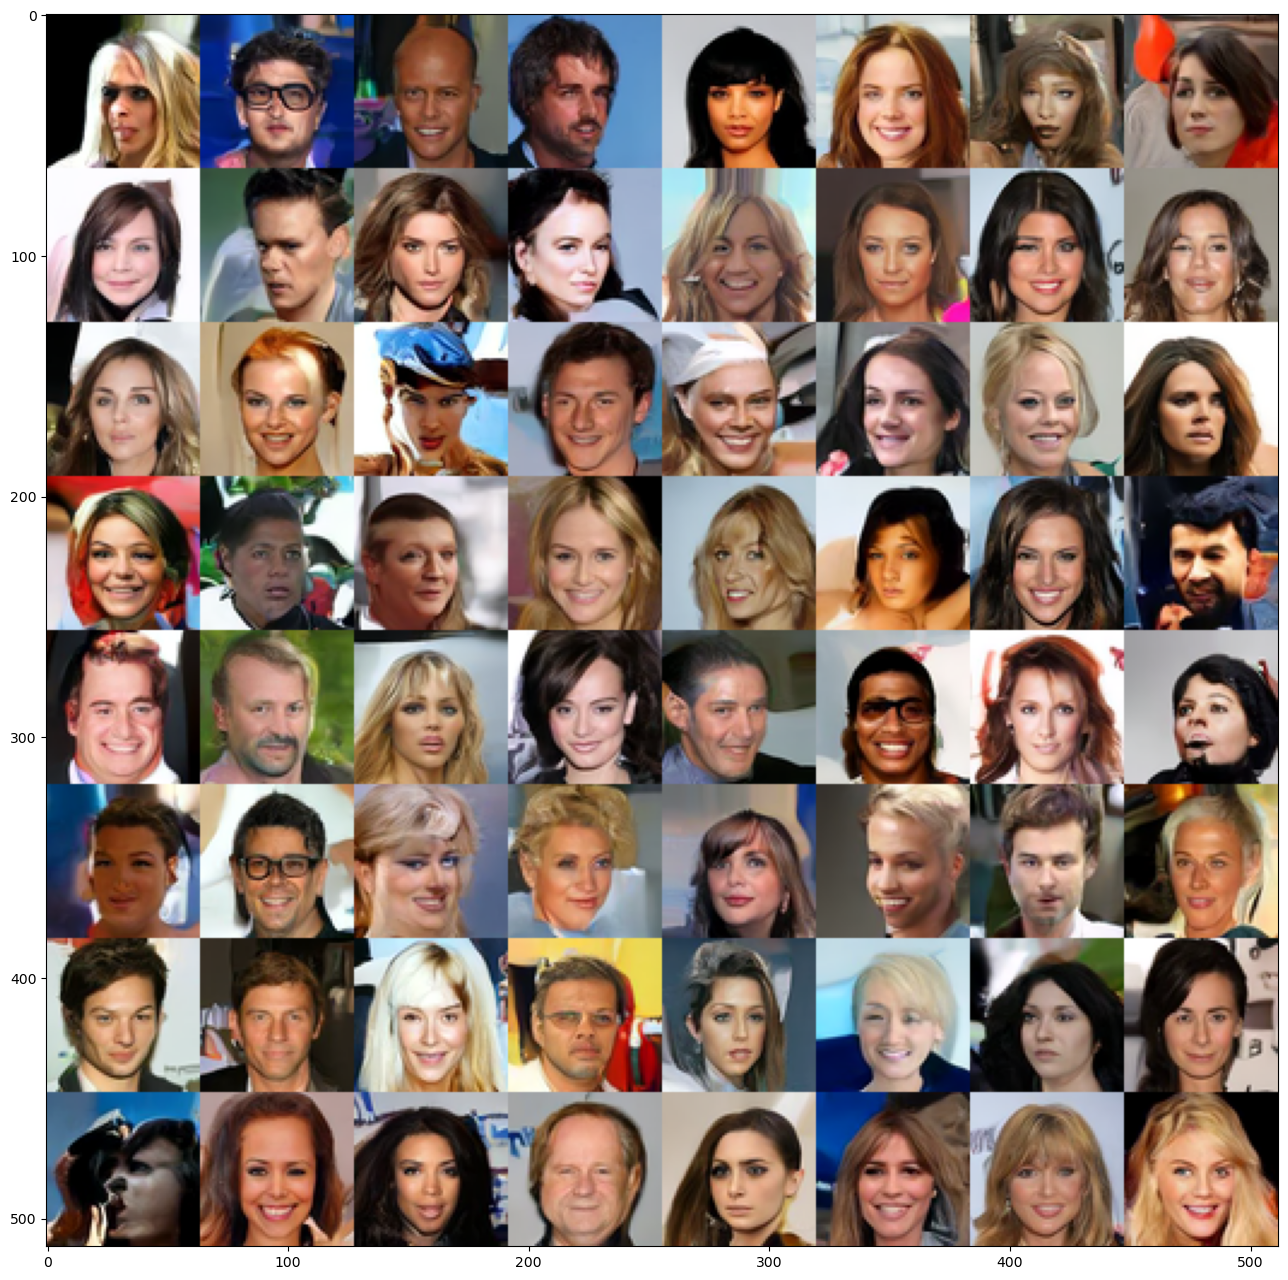

In [45]:
grid = sample_lms(model_ema, size)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(grid)